In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators
import scienceplots
from glob import glob
from tools import get_best_model,get_predictions_per_subset,mertens
import os
from scipy.stats import norm
plt.style.use(["science"])
from copy import deepcopy as cp
from tqdm import tqdm

# Referee 1 wanted to see what would happen in the vd sidm
So to do this I will get the predictions of the standard model for different mass halos and plots against true.

In [78]:
model_name = 'inception'
simulationNames = ['vdSIDM']
channels=['total','stellar','xray']
random_state=0
epochs=10

In [80]:
train, test, allparams = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, train_split=0.01,
                                                      allDataFile='pickles/binned_data_20_vdsidm.pkl', 
                                                      random_state=random_state, return_test_params=True,
                                      galaxy_member_lim=1)  

test_this = test[0][ allparams['sim'] == '%s+baryons' % simulationNames[0] ]
this_params = {}
for ik in allparams.keys():
    this_params[ ik ] = allparams[ ik ][ allparams['sim'] =='%s+baryons' % simulationNames[0] ]

In [ ]:
nBins=10

mass_bins = np.linspace(np.min(this_params['mass']),np.max(this_params['mass']),nBins+1)
bin_centres = 0.5*(mass_bins[1:]+mass_bins[:-1])
nImages = this_params['mass'].shape[0]
nperbin = np.floor(nImages/nBins)
ntrainhalos = []
predictions = np.zeros((2, nBins))
monteCarloModels = glob("models/%s/*" % model_name )
allProbs = []

for iBin in tqdm(range(nBins)):
    inbin = ( this_params['mass'] >= mass_bins[iBin] ) & \
        (this_params['mass'] <= mass_bins[iBin+1])
        
    ntrainhalos.append(this_params['mass'][bin_idxs].shape)

    probability = []
    for iMonteCarlo in monteCarloModels:
        model = get_best_model( train, test,  model_name='Inception', 
                   checkpoint_filepath=iMonteCarlo, epochs=epochs) 
        probability.append(model.predict( test_this[ inbin ], verbose=0 ))
        
    probability = np.array(probability)
    
    allProbs.append(probability)
    
pkl.dump([predictions, allProbs], open("pickles/vdsidm_ideal.pkl","wb"))

In [216]:
nBins=10

mass_bins = np.linspace(np.min(this_params['mass']),np.max(this_params['mass']),nBins+1)
bin_centres = 0.5*(mass_bins[1:]+mass_bins[:-1])
nImages = this_params['mass'].shape[0]
nperbin = np.floor(nImages/nBins)
ntrainhalos = []
monteCarloModels = glob("models/%s/*" % model_name )
predictions, allProbs = pkl.load(open("pickles/vdsidm_ideal.pkl","rb"))

#collate bins
last_bin = -2
lastBins = np.hstack( [ i for i in allProbs[last_bin:]])
rebin_allprobs = allProbs[:last_bin] + [lastBins]
nBins = len(rebin_allprobs)



predictions = np.zeros((2, nBins))
bin_centres = np.append( bin_centres[:last_bin], np.mean(bin_centres[last_bin:]))
for iBin in range(nBins):
        

    these_probs = np.exp(np.array(rebin_allprobs[iBin]))
    these_probs = these_probs/np.sum(these_probs,axis=-1)[:,:,np.newaxis]   
    
    sample = np.max([1, these_probs.shape[1]//10])
    print(sample)
    iPred, iErr = \
        get_predictions_per_subset( these_probs, sample, cross_sections = [0.,0.1,1.0])
   
    predictions[ 0, iBin ] = np.mean(iPred)
    predictions[ 1, iBin ] = np.std(iPred)


76
48
26
15
7
2
1
1
1


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/vdsidm.pdf'.


0

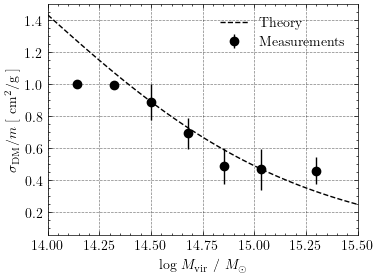

In [222]:
from astropy.modeling.physical_models import NFW
from astropy.units.core import Unit

#Theoretical distribution
m = np.logspace(14, 16, 100)
nfws = [ NFW( mass=i*Unit('solMass'), massfactor='virial') for i in m ]
v = np.array([i.circular_velocity(i.r_virial.to(Unit('kpc'))).to_value() for i in nfws ])
w = 560.
sigma_0 = 3.04
sigma_vd = sigma_0 / (1+v**2/w**2)
####

mass_bin_centres = 10**bin_centres

fig = plt.figure(figsize=(4,3))
plt.plot(np.log10(m), sigma_vd, 'k--', label='Theory')

plt.errorbar(np.log10(mass_bin_centres), predictions[0], yerr=predictions[1], fmt='ko', label='Measurements')
#plt.xscale('log')
plt.xlim(14., 15.5)
plt.xlabel(r'log $M_{\rm vir}$ / $M_\odot$')
plt.ylabel(r'$\sigma_{\rm DM}/m$ [ cm$^2$/g ]')
plt.legend()
filename = '../plots/vdsidm.pdf'
plt.savefig(filename)
os.system('pdfcrop %s %s' % (filename, filename))